In [ ]:
!pip install pyspark py4j

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
spark = SparkSession.builder.master('local[*]').appName('FordGoBike').getOrCreate()

In [ ]:
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bike_data = spark.read.format('csv').option('header', 'true').load('/content/drive/MyDrive/bike_data.csv')

WEEK ONE

In [ ]:
#calculate the total distance for each bike and list the top 10 | task 1
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, sum


total_distance_per_bike = bike_data.groupBy("bike_id").agg(sum("distance_km").alias("total_distance"))

top_10_bikes = total_distance_per_bike.orderBy("total_distance", ascending=False).limit(10)

top_10_bikes.show()

+-------+-----------------+
|bike_id|   total_distance|
+-------+-----------------+
|     68|743.3694820484664|
|   2178| 721.182243221356|
|    256| 671.916097882985|
|    235| 670.162003168386|
|   2049| 656.828101766426|
|    441|656.6422746252357|
|   2226|647.8232304063756|
|    796|646.8677297229267|
|    190| 640.294181741224|
|   2365|639.4126742864064|
+-------+-----------------+



In [ ]:
top_10_bikes.write.csv('top_10_bikes.csv')

In [ ]:
#calculate the number of trips for each start station list top 10 and find the ratio of using as male or female | task 2

station_counts = bike_data.groupBy("start_station_id").agg(count("*").alias("total_trips"))

gender_counts = bike_data.groupBy("start_station_id").agg(
    sum(when(col("member_gender") == "Male", 1).otherwise(0)).alias("male_trips"),
    sum(when(col("member_gender") == "Female", 1).otherwise(0)).alias("female_trips")
)

combined_counts = station_counts.join(gender_counts, "start_station_id", "inner")

combined_counts = combined_counts.withColumn("male_to_female_ratio",
                                             combined_counts["male_trips"] / combined_counts["female_trips"])

top_10_stations = combined_counts.orderBy("total_trips", ascending=False).limit(10)

top_10_stations.show()

+----------------+-----------+----------+------------+--------------------+
|start_station_id|total_trips|male_trips|female_trips|male_to_female_ratio|
+----------------+-----------+----------+------------+--------------------+
|              15|      15187|      8586|        2819|   3.045760908123448|
|               6|      13664|      7444|        1938|  3.8410732714138285|
|              30|      12546|      9813|        2035|   4.822113022113022|
|              67|      12055|      9409|        2105|   4.469833729216152|
|              58|      11960|      9005|        1870|   4.815508021390374|
|              21|      11334|      8367|        1631|  5.1299816063764565|
|              81|      10956|      7773|        2302|  3.3766290182450045|
|               3|      10142|      6070|        1768|   3.433257918552036|
|              22|       9926|      7512|        1980|   3.793939393939394|
|              16|       9347|      6532|        1740|   3.754022988505747|
+-----------

In [ ]:
#-make a comparison to find the percentage of usage for customer and subscriber | task 3

user_type_counts = bike_data.groupBy('user_type').agg(count('*').alias('total_trips'))

total_trips_sum = user_type_counts.agg({"total_trips": "sum"}).collect()[0][0]
user_type_counts = user_type_counts.withColumn("percentage_of_usage",
                                               (user_type_counts["total_trips"] / total_trips_sum) * 100)

user_type_counts.show()

+----------+-----------+-------------------+
| user_type|total_trips|percentage_of_usage|
+----------+-----------+-------------------+
|Subscriber|     409230|  78.74350586877044|
|  Customer|     110470| 21.256494131229555|
+----------+-----------+-------------------+



In [ ]:
#calculate the age of all users and show the relation between the distance and the age | task 4

from pyspark.sql.functions import year, current_date

current_year = year(current_date())

bike_data = bike_data.withColumn('age', current_year - col('member_birth_year'))

bike_data.select('age', 'distance_km').show()


+----+------------------+
| age|       distance_km|
+----+------------------+
|36.0| 0.942930697721659|
|58.0| 3.069730208886286|
|NULL|               0.0|
|NULL|1.0466240808449843|
|26.0|0.6363402624770698|
|NULL|               0.0|
|32.0|               0.0|
|NULL|               0.0|
|NULL|               0.0|
|NULL|               0.0|
|NULL|0.7713016224936289|
|NULL|0.7713016224936289|
|33.0| 1.517350517786709|
|33.0| 1.517350517786709|
|NULL|1.4225965058298293|
|43.0|  1.05026380421915|
|44.0|  1.05026380421915|
|NULL|2.8563367873003527|
|35.0|2.8563367873003527|
|52.0|2.8592460098833117|
+----+------------------+
only showing top 20 rows



In [ ]:
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


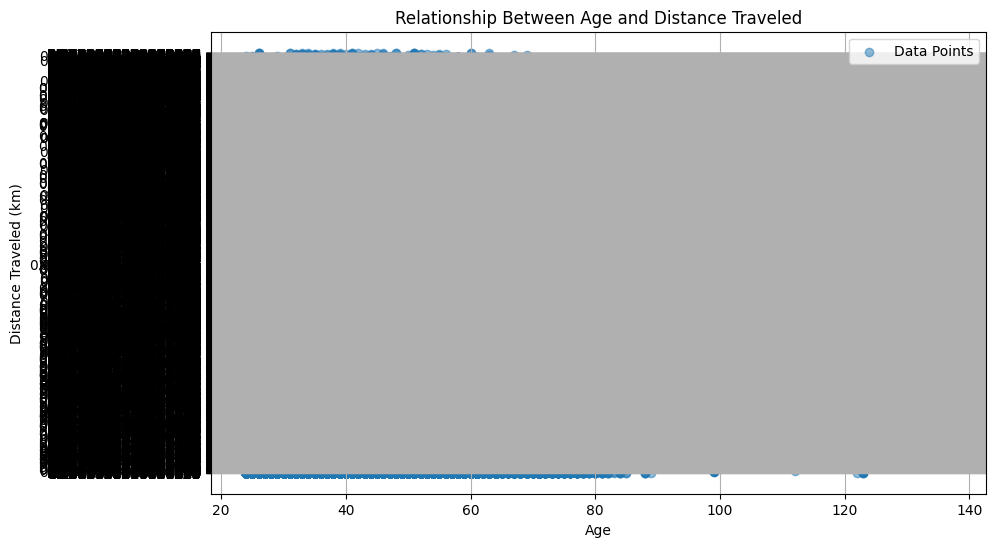

In [ ]:
# age-distance plot | task 4
import matplotlib.pyplot as plt

current_year = year(current_date())

bike_data = bike_data.withColumn('age', current_year - col('member_birth_year'))

plt.figure(figsize=(10, 6))
plt.scatter(bike_data.select("age").rdd.flatMap(lambda x: x).collect(),
            bike_data.select("distance_km").rdd.flatMap(lambda x: x).collect(),
            alpha=0.5, label="Data Points")
plt.xlabel('Age')
plt.ylabel('Distance Traveled (km)')
plt.title('Relationship Between Age and Distance Traveled')
plt.legend()
plt.grid(True)

plt.show()



In [ ]:
from pyspark.sql.functions import max, min

min_byear = bike_data.select(min("member_birth_year")).first()[0]

print("Minimum birth year:", min_byear)

Minimum birth year: 1886.0


In [ ]:
#1-calculate the total cost for all customers and all subscribers | task 1

user_type_counts = bike_data.groupBy('user_type').agg(sum('fee').alias('total_cost'))

user_type_counts.show()

+----------+------------------+
| user_type|        total_cost|
+----------+------------------+
|Subscriber|1684845.4408333309|
|  Customer| 1648191.084166668|
+----------+------------------+



In [ ]:
#what is the ratio of payment using credit card and app wallet | task 4

payment_method_counts = bike_data.groupBy("pyment").agg(count("*").alias("count"))

total_count_all_methods = payment_method_counts.agg(sum("count")).collect()[0][0]

credit_card_count = payment_method_counts.filter(payment_method_counts["pyment"] == "credit card").collect()[0]["count"]
app_wallet_count = payment_method_counts.filter(payment_method_counts["pyment"] == "app wallet").collect()[0]["count"]

credit_card_ratio = credit_card_count / total_count_all_methods
app_wallet_ratio = app_wallet_count / total_count_all_methods

print("Credit Card Usage Ratio:", credit_card_ratio)
print("App Wallet Usage Ratio:", app_wallet_ratio)


Credit Card Usage Ratio: 0.49959399653646336
App Wallet Usage Ratio: 0.5004060034635367


In [ ]:
#what is the preferred way to pay for customers and subscriber | task 5

user_type_countss = bike_data.groupBy("user_type").agg(count("*").alias("user_type_count"))


payment_counts = bike_data.groupBy("user_type").agg(
    sum(when(col("pyment") == "credit card", 1).otherwise(0)).alias("cc_payment"),
    sum(when(col("pyment") == "app wallet", 1).otherwise(0)).alias("aw_payment")
)


combined_counts = user_type_counts.join(payment_counts, "user_type", "inner")

preferred_payment = combined_counts.orderBy("user_type", ascending=False)

preferred_payment.show()


+----------+------------------+----------+----------+
| user_type|        total_cost|cc_payment|aw_payment|
+----------+------------------+----------+----------+
|Subscriber|1684845.4408333309|    204503|    204727|
|  Customer| 1648191.084166668|     55136|     55334|
+----------+------------------+----------+----------+



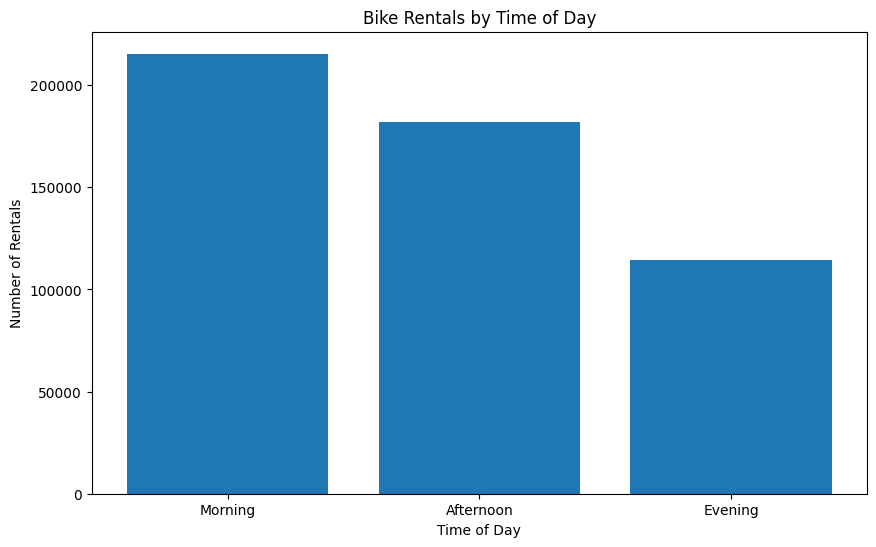

In [ ]:
#Analyze how often bikes are being rented ( morning 6—12 am afternoon 12-6 pm - evening 6-12 pm)
# and at what times of day (make a bar chart) | TASK 2

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

bike_data = bike_data.withColumn("hour", F.hour("start_datetime"))

time_intervals = [
    {"name": "Morning", "start": 6, "end": 12},
    {"name": "Afternoon", "start": 13, "end": 17},
    {"name": "Evening", "start": 18, "end": 23}
]

for interval in time_intervals:
    bike_data = bike_data.withColumn(interval["name"],
                                     F.when((F.col("hour") >= interval["start"]) & (F.col("hour") <= interval["end"]), 1).otherwise(0))

time_interval_counts = bike_data.groupBy().agg(
    *[F.sum(interval["name"]).alias(interval["name"]) for interval in time_intervals]
)

time_interval_counts_df = time_interval_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(time_interval_counts_df.columns, time_interval_counts_df.iloc[0])
plt.xlabel("Time of Day")
plt.ylabel("Number of Rentals")
plt.title("Bike Rentals by Time of Day")
plt.show()



In [ ]:
station_time_counts = bike_data.groupBy("start_station_id").agg(
    *[F.sum(interval["name"]).alias(interval["name"] + "_count") for interval in time_intervals]
)

# Show the result
station_time_counts.show()

+----------------+-------------+---------------+-------------+
|start_station_id|Morning_count|Afternoon_count|Evening_count|
+----------------+-------------+---------------+-------------+
|             296|          283|            269|           86|
|             125|          882|            465|          376|
|               7|          672|           1225|          982|
|             124|          697|            535|          329|
|             307|           70|            113|          105|
|             205|          177|             55|           29|
|             169|          204|            136|           49|
|             232|          226|            179|          114|
|              15|         9143|           4341|         1656|
|             282|          118|            204|          103|
|             234|           12|             37|           21|
|             317|          240|            103|          189|
|             132|          793|            310|       

In [ ]:
station_time_counts.write.csv('station_time_counts.csv')

WEEK THREE

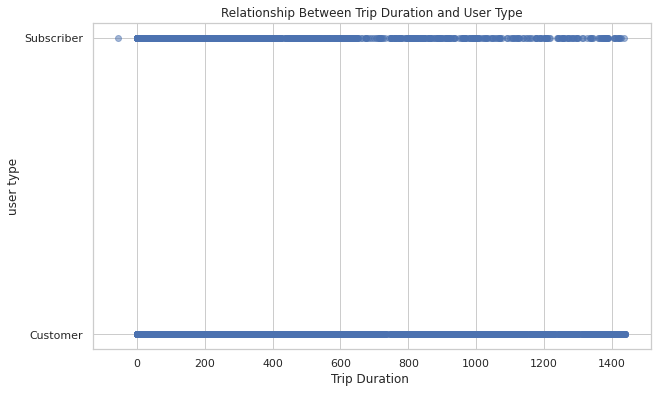

In [ ]:
#Analyze the relationship between trip duration and
#user type( sub vs customer) to understand differences in usage patterns

import matplotlib.pyplot as plt
from pyspark.sql.functions import year, current_date

plt.figure(figsize=(10, 6))
plt.scatter(bike_data.select("date_difference_minutes").rdd.flatMap(lambda x: x).collect(), bike_data.select("user_type").rdd.flatMap(lambda x: x).collect(), alpha=0.5)
plt.xlabel('Trip Duration ')
plt.ylabel('user type')
plt.title('Relationship Between Trip Duration and User Type')
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
bike_data = bike_data.withColumn('date_difference_minutes', col('date_difference_seconds') / 60)
bike_data = bike_data.withColumn('date_difference_hour', col('date_difference_minutes') / 60)
bike_data.show(3)

+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------+-----------------+-------------+-----------+-----------------+---------------+-----------------------+------------------+----+----+-------+---------+-------+-----------------------+--------------------+
|     start_datetime|       end_datetime|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id|user_type|member_birth_year|member_gender|     pyment|      distance_km|     difference|date_difference_seconds|               fee| age|hour|Morning|Afternoon|Evening|date_difference_minutes|date_difference_hour|
+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+-------

In [ ]:
from pyspark.sql.functions import *

avg_trip = bike_data.groupBy("user_type").agg(mean("date_difference_minutes").alias("avg_trip_duration"))

avg_trip.show()


#Subscribers have a much shorter average trip duration compared to customers. This indicates that subscribers typically take shorter trips on average, suggesting that they might use the service for daily commutes or short, regular trips.

#Customers, on the other hand, have a significantly longer average trip duration, indicating that they take longer trips on average. This could mean that customers use the service for leisure or occasional travel, which tends to be of longer duration.

+----------+------------------+
| user_type| avg_trip_duration|
+----------+------------------+
|Subscriber|11.763175027897955|
|  Customer| 42.62802012612796|
+----------+------------------+



In [ ]:
trip_duration_column = bike_data.select('date_difference_minutes')

In [ ]:
trip_duration_series = trip_duration_column.toPandas()["date_difference_minutes"]

In [ ]:
import pandas as pd
trip_duration_data = pd.DataFrame({"date_difference_minutes": trip_duration_series})

<ipython-input-26-5d6e70c40ee4>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_duration_data["date_difference_minutes"], shade=True, color="b")


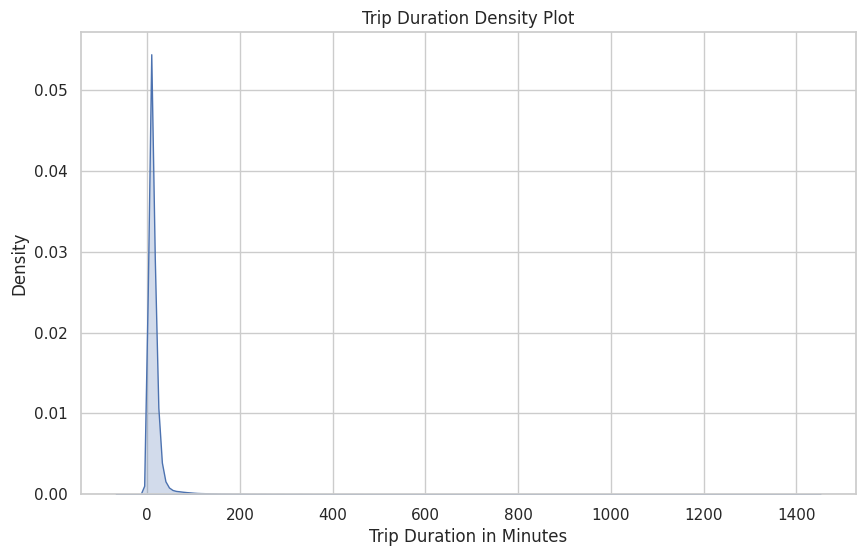

In [ ]:
import seaborn as sns
# Create a density plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(trip_duration_data["date_difference_minutes"], shade=True, color="b")

# Add labels and a title
plt.xlabel("Trip Duration in Minutes")
plt.ylabel("Density")
plt.title("Trip Duration Density Plot")

# Show the plot
plt.show()

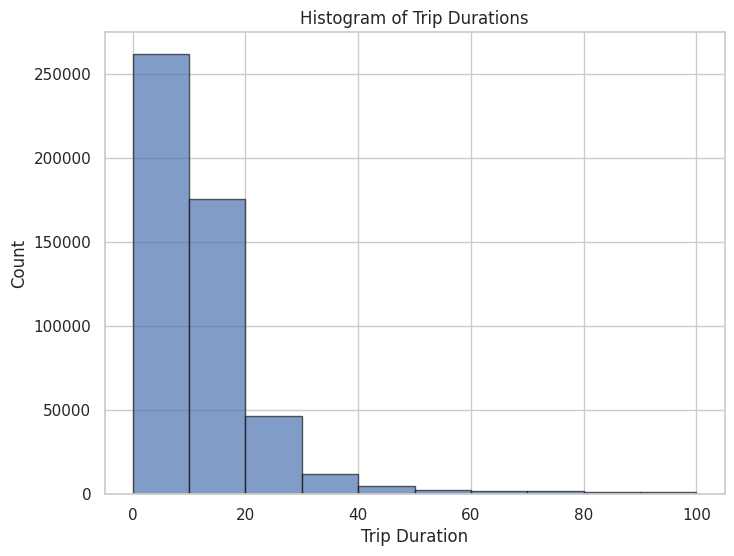

In [ ]:
import matplotlib.pyplot as plt

custom_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(8, 6))
plt.hist(trip_duration_data["date_difference_minutes"], bins=custom_bins, color="b", alpha=0.7, edgecolor="k")

plt.xlabel("Trip Duration")
plt.ylabel("Count")
plt.title("Histogram of Trip Durations")

plt.show()

#half of the users drop after 10 minutes, so we can suggest that every 10 minute the fee gradually decreases
#for example in the beginning its 0.35 cent and after the first 10 minutes we can try to descrease it by 15% to 0.2975

In [ ]:
bike_data.count()

Out[30]: 519700

In [ ]:
bike_data = bike_data.withColumn("route", concat_ws(" - ", col("start_station_name"), col("end_station_name")))

In [ ]:
bike_data.select('route').show(1)

+--------------------+
|               route|
+--------------------+
|Laguna St at Haye...|
+--------------------+
only showing top 1 row



In [ ]:
route_grouped = bike_data.groupBy("route").agg(count("*").alias("total")).orderBy('total', ascending=False)
route_grouped.show()

+--------------------+-----+
|               route|total|
+--------------------+-----+
|San Francisco Fer...| 3344|
|The Embarcadero a...| 1793|
|The Embarcadero a...| 1734|
|Berry St at 4th S...| 1686|
|2nd St at S Park ...| 1509|
|Montgomery St BAR...| 1485|
|San Francisco Fer...| 1401|
|Steuart St at Mar...| 1361|
|2nd St at Townsen...| 1274|
|19th Street BART ...| 1196|
|The Embarcadero a...| 1190|
|Howard St at Beal...| 1183|
|Market St at 10th...| 1148|
|San Francisco Fer...| 1105|
|Howard St at 2nd ...| 1100|
|Bay Pl at Vernon ...| 1054|
|Grand Ave at Perk...| 1041|
|The Embarcadero a...| 1037|
|5th St at Howard ...| 1031|
|Montgomery St BAR...|  987|
+--------------------+-----+
only showing top 20 rows



In [ ]:
route_grouped2 = bike_data.groupBy('route').agg(sum('fee').alias('total_fee'))

In [ ]:
merge_route = route_grouped.join(route_grouped2, route_grouped['route'] == route_grouped2['route'], 'outer')


+--------------------+-----+--------------------+------------------+
|               route|total|               route|         total_fee|
+--------------------+-----+--------------------+------------------+
|10th Ave at E 15t...|   16|10th Ave at E 15t...| 49.18666666666667|
|10th Ave at E 15t...|    2|10th Ave at E 15t...| 8.919166666666666|
|10th Ave at E 15t...|    2|10th Ave at E 15t...|24.826666666666664|
|10th Ave at E 15t...|    6|10th Ave at E 15t...|             25.62|
|10th Ave at E 15t...|    2|10th Ave at E 15t...|            15.645|
|10th Ave at E 15t...|    2|10th Ave at E 15t...|11.701666666666666|
|10th Ave at E 15t...|    7|10th Ave at E 15t...|30.881666666666664|
|10th Ave at E 15t...|    5|10th Ave at E 15t...| 44.94583333333333|
|10th Ave at E 15t...|    4|10th Ave at E 15t...|            66.605|
|10th Ave at E 15t...|    5|10th Ave at E 15t...|105.43166666666664|
|10th Ave at E 15t...|    1|10th Ave at E 15t...|              6.02|
|10th Ave at E 15t...|   28|10th A

In [ ]:
merge_route = merge_route.drop(route_grouped2.route)

In [ ]:
distance_route = bike_data.groupBy('route').agg(sum('distance_km').alias('count of distance'))
distance_route.show()

+--------------------+------------------+
|               route| count of distance|
+--------------------+------------------+
|20th St at Bryant...|               0.0|
|Commercial St at ...|19.409013609959082|
|47th St at San Pa...| 2.448050463515122|
|Division St at Po...| 192.6869023068837|
|18th St at Noe St...|   34.672519307652|
|Spear St at Folso...| 29.23568172322822|
|2nd Ave at E 18th...| 102.6118863379962|
|29th St at Tiffan...| 53.32599086737302|
|Golden Gate Ave a...| 2.825806735058541|
|5th St at Brannan...|226.14127122009324|
|Valencia St at 21...|  74.5303752114064|
|Lakeshore Ave at ...|237.77866685896726|
|Golden Gate Ave a...| 25.30129952858443|
|13th St at Frankl...| 1.766225403986619|
|College Ave at Ha...|59.873005318948486|
|Union Square (Pow...| 39.12392445780438|
|Fruitvale BART St...| 5.259884355925762|
|Franklin St at 9t...| 74.49471105735405|
|San Francisco Cit...| 24.24979080234874|
|Powell St BART St...|  70.3122234394888|
+--------------------+------------

In [ ]:
merge_dis_fee = distance_route.join(merge_route, distance_route['route'] == merge_route['route'], 'outer')

merge_dis_fee.show()


+--------------------+------------------+-----+--------------------+------------------+
|               route| count of distance|total|               route|         total_fee|
+--------------------+------------------+-----+--------------------+------------------+
|10th Ave at E 15t...| 21.84845702897097|   16|10th Ave at E 15t...| 49.18666666666667|
|10th Ave at E 15t...| 4.983973250928234|    2|10th Ave at E 15t...| 8.919166666666666|
|10th Ave at E 15t...| 9.655432671392823|    2|10th Ave at E 15t...|24.826666666666664|
|10th Ave at E 15t...| 10.77431982037442|    6|10th Ave at E 15t...|             25.62|
|10th Ave at E 15t...| 7.328434103462173|    2|10th Ave at E 15t...|            15.645|
|10th Ave at E 15t...| 5.013266193157361|    2|10th Ave at E 15t...|11.701666666666666|
|10th Ave at E 15t...|15.625039824972074|    7|10th Ave at E 15t...|30.881666666666664|
|10th Ave at E 15t...|11.117541076540649|    5|10th Ave at E 15t...| 44.94583333333333|
|10th Ave at E 15t...| 22.382248

In [ ]:
merge_dis_fee = merge_dis_fee.drop(distance_route.route)

In [ ]:
merge_dis_fee.show()

+------------------+-----+--------------------+------------------+
| count of distance|total|               route|         total_fee|
+------------------+-----+--------------------+------------------+
| 21.84845702897097|   16|10th Ave at E 15t...| 49.18666666666667|
| 4.983973250928234|    2|10th Ave at E 15t...| 8.919166666666666|
| 9.655432671392823|    2|10th Ave at E 15t...|24.826666666666664|
| 10.77431982037442|    6|10th Ave at E 15t...|             25.62|
| 7.328434103462173|    2|10th Ave at E 15t...|            15.645|
| 5.013266193157361|    2|10th Ave at E 15t...|11.701666666666666|
|15.625039824972074|    7|10th Ave at E 15t...|30.881666666666664|
|11.117541076540649|    5|10th Ave at E 15t...| 44.94583333333333|
| 22.38224871767608|    4|10th Ave at E 15t...|            66.605|
| 9.607453474318154|    5|10th Ave at E 15t...|105.43166666666664|
|2.2314521762210764|    1|10th Ave at E 15t...|              6.02|
|43.145909272012744|   28|10th Ave at E 15t...|104.10749999999

In [ ]:
merge_dis_fee.write.csv('merged_distance_fee.csv')

In [ ]:
route_grouped.write.csv('route.csv')

In [ ]:
bike_data = bike_data.withColumn("Month", month(col("start_datetime")))

In [ ]:
bike_data = bike_data.withColumn(
    "Season",
    when((month("start_datetime") >= 12) | (month("start_datetime") <= 2), "Winter")
    .when((month("start_datetime") >= 3) & (month("start_datetime") <= 5), "Spring")
    .when((month("start_datetime") >= 6) & (month("start_datetime") <= 8), "Summer")
    .when((month("start_datetime") >= 9) & (month("start_datetime") <= 11), "Fall")
    .otherwise("Unknown")
)

In [ ]:
trip_season = bike_data.groupBy('Season').agg(count('*').alias('total_count'))
trip_season.show()

+------+-----------+
|Season|total_count|
+------+-----------+
|  Fall|     303107|
|Winter|      86539|
|Summer|     130054|
+------+-----------+



In [ ]:
start_station_total = bike_data.groupBy('start_station_id').agg(count('*').alias('total_trips_starts'))
end_station_total = bike_data.groupBy('end_station_id').agg(count('*').alias('total_trips_ends'))
merged_station_total = start_station_total.join(end_station_total, start_station_total['start_station_id'] == end_station_total['end_station_id'], 'outer')

merged_station_total.show()

+----------------+------------------+--------------+----------------+
|start_station_id|total_trips_starts|end_station_id|total_trips_ends|
+----------------+------------------+--------------+----------------+
|              10|              2310|            10|            2696|
|             100|              1567|           100|            1541|
|             101|               873|           101|             929|
|             102|              1071|           102|            1375|
|             105|              1481|           105|             889|
|             106|              1100|           106|             976|
|             107|              1607|           107|            1355|
|             108|               925|           108|             991|
|             109|              3053|           109|            3214|
|              11|              3474|            11|            3893|
|             110|              1021|           110|            1123|
|             112|  

In [ ]:
merged_station_total = merged_station_total.withColumn('ratio', (col('total_trips_ends') / col('total_trips_starts'))).orderBy('ratio', ascending=False)
merged_station_total.show()

+----------------+------------------+--------------+----------------+------------------+
|start_station_id|total_trips_starts|end_station_id|total_trips_ends|             ratio|
+----------------+------------------+--------------+----------------+------------------+
|             268|                 1|           268|               2|               2.0|
|             157|               617|           157|            1021|1.6547811993517019|
|             151|               149|           151|             234| 1.570469798657718|
|             247|               739|           247|            1118|1.5128552097428958|
|             339|                 2|           339|               3|               1.5|
|             226|                41|           226|              61|1.4878048780487805|
|             245|              1667|           245|            2342|1.4049190161967606|
|             263|                35|           263|              49|               1.4|
|              30|   

In [ ]:
merged_station_total.write.csv('merged_station2.csv')

In [ ]:
trip_season.write.csv('seasons.csv')

In [ ]:
merged_stations_times = station_time_counts.join(merged_station_total, station_time_counts['start_station_id'] == merged_station_total['start_station_id'], 'outer')
merged_stations_times = merged_stations_times.orderBy('ratio', ascending=False)


In [ ]:
merged_stations_times.show(30)

+----------------+-------------+---------------+-------------+----------------+------------------+--------------+----------------+------------------+
|start_station_id|Morning_count|Afternoon_count|Evening_count|start_station_id|total_trips_starts|end_station_id|total_trips_ends|             ratio|
+----------------+-------------+---------------+-------------+----------------+------------------+--------------+----------------+------------------+
|             268|            1|              0|            0|             268|                 1|           268|               2|               2.0|
|             157|          245|            242|          120|             157|               617|           157|            1021|1.6547811993517019|
|             151|           63|             53|           33|             151|               149|           151|             234| 1.570469798657718|
|             247|          154|            311|          254|             247|               739|  

In [ ]:
trips_starting = bike_data.groupBy("start_station_name").agg(count("*").alias("start_counting"))
trips_ending = bike_data.groupBy("end_station_name").agg(count("*").alias("end_counting"))



In [ ]:
# Calculate net change in bike availability
station_data = trips_starting.join(trips_ending, trips_starting['start_station_name'] == trips_ending['end_station_name'], "outer").fillna(0)



In [ ]:
station_data.show()

+--------------------+-----------+--------------------+---------+
|  start_station_name|start_count|    end_station_name|end_count|
+--------------------+-----------+--------------------+---------+
|10th Ave at E 15t...|        194|10th Ave at E 15t...|      248|
|10th St at Fallon St|       1520|10th St at Fallon St|     1848|
|11th St at Bryant St|       1760|11th St at Bryant St|     2014|
|11th St at Natoma St|       2038|11th St at Natoma St|     2184|
|  12th St at 4th Ave|        993|  12th St at 4th Ave|     1080|
|  12th St at 6th Ave|        241|  12th St at 6th Ave|      283|
|13th St at Frankl...|         61|13th St at Frankl...|       48|
|14th St at Filber...|        105|14th St at Filber...|      111|
|14th St at Mandel...|        695|14th St at Mandel...|      661|
|14th St at Missio...|       2277|14th St at Missio...|     2157|
|16th St Mission BART|        925|16th St Mission BART|      991|
|16th St Mission B...|       1436|16th St Mission B...|     1688|
|16th St a